# Feature Engineering

Questions to be considered:


1. Group the restaurants by cuisines
2. Cuisines types: asian, european, north america, south america, other (cannot classify)
3. EDA for each cuisine



In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Learn how to import data from https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

# there will be a prompt for authentication. Follow the link, click yes, and copy the token

# get name of the files in folder
!ls "/content/gdrive/My Drive/YELP/yelp-csv/"


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
restaurant.csv	     vegas_cuisine.gsheet	   yelp_review.csv
restaurant.gsheet    yelp_business_attributes.csv  yelp_tip.csv
restaurant_open.csv  yelp_business.csv		   yelp_user.csv
vegas_cuisine.csv    yelp_checkin.csv


**Part 1: Data cleaning**
The first part is the same as our previous EDA notebook.

In [0]:
biz_file_path = '/content/gdrive/My Drive/YELP/yelp-csv/restaurant_open.csv'
biz_att_file_path = '/content/gdrive/My Drive/YELP/yelp-csv/yelp_business_attributes.csv'
biz_df = pd.read_csv(biz_file_path )
biz_att = pd.read_csv(biz_att_file_path )
data = pd.merge(biz_df,biz_att, on='business_id')

In [0]:
data.replace(to_replace='True', value = 1,inplace=True)
data.replace(to_replace='False', value = 0,inplace=True)
data.replace(to_replace='Na', value = 0.5,inplace=True) #only treat this as a categorical variable

In [0]:
data.replace(to_replace= ['beer_and_wine','casual','free',
            'full_bar','loud', 'outdoor', 'quiet','yes','yes_free', '1', '2'], value = 1,inplace=True)
data.replace(to_replace=['no', 'none'], value = 0,inplace=True)

In [0]:
att = data.iloc[:,16:]

In [0]:
features = ['Unnamed: 0',
 'business_id',
 'name',
 'neighborhood',
 'address',
 'city',
 'state',
 'postal_code',
 'latitude',
 'longitude',
 'stars',
 'review_count',
 'is_open',
 'categories',
 'hours',]

In [0]:
d = att.apply(pd.value_counts)
col_names = d.columns.tolist()

In [0]:
d = d.drop(columns ='HairSpecializesIn_coloring')

In [0]:
col = d.loc[:,~(d == att.shape[0]).any()].columns.tolist()
# d.loc[:,~(d == float(att.shape[0])).any()]

In [0]:
colnames = features + col
dataclean = data[colnames]

In [0]:
vegas_clean = dataclean[dataclean['city']=='Las Vegas']
vegas_clean.head()

,Unnamed: 0,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,hours,BusinessAcceptsCreditCards,BusinessParking_garage,BusinessParking_street,BusinessParking_validated,BusinessParking_lot,BusinessParking_valet,GoodForKids,WheelchairAccessible,BikeParking,Alcohol,HasTV,NoiseLevel,RestaurantsAttire,Music_dj,Music_background_music,Music_no_music,Music_karaoke,Music_live,Music_video,Music_jukebox,Ambience_romantic,Ambience_intimate,Ambience_classy,Ambience_hipster,Ambience_divey,...,Ambience_upscale,Ambience_casual,RestaurantsGoodForGroups,Caters,WiFi,RestaurantsReservations,RestaurantsTakeOut,HappyHour,GoodForDancing,RestaurantsTableService,OutdoorSeating,RestaurantsDelivery,BestNights_monday,BestNights_tuesday,BestNights_friday,BestNights_wednesday,BestNights_thursday,BestNights_sunday,BestNights_saturday,GoodForMeal_dessert,GoodForMeal_latenight,GoodForMeal_lunch,GoodForMeal_dinner,GoodForMeal_breakfast,GoodForMeal_brunch,CoatCheck,Smoking,DriveThru,DogsAllowed,BusinessAcceptsBitcoin,Open24Hours,BYOB,DietaryRestrictions_gluten-free,DietaryRestrictions_vegan,DietaryRestrictions_kosher,DietaryRestrictions_halal,DietaryRestrictions_soy-free,DietaryRestrictions_vegetarian,AgesAllowed,RestaurantsCounterService
8,32,kgffcoxT6BQp-gJ-UQ7Czw,Subway,Summerlin,2255 N Rampart Blvd,Las Vegas,NV,89128,36.201794,-115.281981,2.5,13,1,"Fast Food, Restaurants, Sandwiches","{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...",0.5,0.5,0.0,0.0,0.0,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
9,33,0jtRI7hVMpQHpUVtUy4ITw,Omelet House Summerlin,Summerlin,2227 N Rampart Blvd,Las Vegas,NV,89128,36.201990,-115.283122,4.0,242,1,"Beer, Wine & Spirits, Italian, Food, American ...","{'Monday': '7:0-14:30', 'Tuesday': '7:0-19:0',...",0.5,0.5,0.0,0.0,0.0,1.0,0.5,0.5,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
32,141,zhxnD7J5_sCrKSw5cwI9dQ,Popeyes Louisiana Kitchen,Sunrise,4505 E Bonanza Rd,Las Vegas,NV,89110,36.173140,-115.077945,1.5,16,1,"Chicken Wings, Restaurants, Fast Food","{'Monday': '10:0-23:0', 'Tuesday': '10:0-23:0'...",0.5,0.5,0.0,0.0,0.0,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
34,143,2kWrSFkIes_d2BMg4YrRtA,Pizza Hut,Sunrise,"560 N. Nellis Blvd, Ste E1",Las Vegas,NV,89110,36.169353,-115.061694,2.5,19,1,"Restaurants, Pizza","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",0.5,0.5,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
35,145,6llKs7K_tn8ChXcIM-oTvg,Sansei Japan,Eastside,3480 S Maryland Pkwy,Las Vegas,NV,89169,36.125934,-115.135253,4.5,3,1,"Japanese, Restaurants",NaN,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


**Part 2: Group the restaurants by cuisines and use cuisine types as new features.**

In [0]:
#Group features by cuisines
asian = 'chinese|japanese|asian|indian|sushi|dim dum|cantonese|ramen|noodles|thai|vietnamese|filipino|korean'
european = 'mediterranean|italian|greek|french|creperies|tapas bars|middle eastern|halal' #remove 'tapas' for now since a korean bbq has it and outperforms the class.
namerica = 'pizza|sandwiches|delis|wraps|chicken wings|chicken shop|hot dogs|cheesesteaks|burgers|american|steak|southern|comfort food|cajun|creole|soul food|fast food'
#remove 'barbeque' for now since a korean bbq has it and outperforms the class.
samerica = 'mexican|latin american|tex-mex|tacos|salvadoran'
other = asian +'|'+ european +'|'+ namerica +'|'+ samerica
other

'chinese|japanese|asian|indian|sushi|dim dum|cantonese|ramen|noodles|thai|vietnamese|filipino|korean|mediterranean|italian|greek|french|creperies|tapas bars|middle eastern|halal|pizza|sandwiches|delis|wraps|chicken wings|chicken shop|hot dogs|cheesesteaks|burgers|american|steak|southern|comfort food|cajun|creole|soul food|fast food|mexican|latin american|tex-mex|tacos|salvadoran'

In [0]:

only_desc = vegas_clean['categories'].str.lower()

with_features = (vegas_clean
 .assign(asian     = only_desc.str.contains(asian))
 .assign(european = only_desc.str.contains(european))
 .assign(namerica    = only_desc.str.contains(namerica))
 .assign(samerica  = only_desc.str.contains(samerica))
 .assign(other = ~only_desc.str.contains(other)))


with_features['class'] = with_features.iloc[:,-5:].sum(axis = 1)
len(with_features.columns)

88

In [0]:
with_features[with_features['asian']==True].describe()

,Unnamed: 0,latitude,longitude,stars,review_count,is_open,BusinessAcceptsCreditCards,BusinessParking_garage,BusinessParking_street,BusinessParking_validated,BusinessParking_lot,BusinessParking_valet,WheelchairAccessible,BikeParking,Alcohol,HasTV,NoiseLevel,Music_dj,Music_background_music,Music_no_music,Music_karaoke,Music_live,Music_video,Music_jukebox,Ambience_romantic,Ambience_intimate,Ambience_classy,Ambience_hipster,Ambience_divey,Ambience_touristy,Ambience_trendy,Ambience_upscale,Ambience_casual,RestaurantsGoodForGroups,Caters,WiFi,RestaurantsTakeOut,HappyHour,GoodForDancing,RestaurantsTableService,OutdoorSeating,RestaurantsDelivery,BestNights_monday,BestNights_tuesday,BestNights_friday,BestNights_wednesday,BestNights_thursday,BestNights_sunday,BestNights_saturday,GoodForMeal_dessert,GoodForMeal_latenight,GoodForMeal_lunch,GoodForMeal_dinner,GoodForMeal_breakfast,GoodForMeal_brunch,CoatCheck,Smoking,DriveThru,DogsAllowed,BusinessAcceptsBitcoin,Open24Hours,BYOB,DietaryRestrictions_gluten-free,DietaryRestrictions_vegan,DietaryRestrictions_kosher,DietaryRestrictions_halal,DietaryRestrictions_soy-free,DietaryRestrictions_vegetarian,AgesAllowed,class
count,710.000000,710.000000,710.000000,710.000000,710.000000,710.0,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.0,710.000000,710.000000,710.0,710.0,710.0,710.0,710.0,710.0,710.0,710.0,710.0,710.0,710.0,710.0,710.0,710.0,710.0,710.0,710.0,710.000000,710.000000,710.000000,710.000000,710.0,710.000000,710.000000,710.000000,710.000000,710.0,710.0,710.0,710.0,710.0,710.0,710.0,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.0,710.0,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000
mean,100284.973239,36.122102,-115.197656,3.704930,298.181690,1.0,0.496479,0.500704,0.174648,0.115493,0.085915,0.628169,0.617606,0.688732,0.5,0.502817,0.499296,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.503521,0.500704,0.499296,0.502817,0.5,0.502817,0.498592,0.499296,0.471831,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.436620,0.440845,0.546479,0.561972,0.425352,0.439437,0.499296,0.501408,0.469718,0.5,0.5,0.500704,0.500704,0.497887,0.499296,0.497887,0.497887,0.499296,0.502113,1.236620
std,55198.026884,0.053408,0.062516,0.657958,384.157903,0.0,0.041841,0.018765,0.320533,0.246354,0.192450,0.438514,0.225115,0.267438,0.0,0.045910,0.018765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041841,0.018765,0.032517,0.037450,0.0,0.045910,0.065033,0.018765,0.191264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.186452,0.187837,0.191373,0.186925,0.182227,0.187387,0.018765,0.045975,0.135924,0.0,0.0,0.018765,0.032517,0.032455,0.032517,0.032455,0.032455,0.032517,0.032455,0.441577
min,145.000000,35.995198,-115.334601,1.500000,3.000000,1.0,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.5,0.000000,0.000000,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.500000,0.500000,0.000000,0.500000,0.5,0.000000,0.000000,0.000000,0.000000,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.5,0.5,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000
25%,50621.000000,36.100515,-115.242993,3.500000,65.250000,1.0,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.5,0.500000,0.500000,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.500000,0.500000,0.500000,0.500000,0.5,0.500000,0.500000,0.500000,0.500000,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.5,0.5,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.000000
50%,104170.000000,36.125208,-115.197855,4.000000,172.500000,1.0,0.500000,0.500000,0.000000,0.000000,0.000000,1.000000,0.500000,0.500000,0.5,0.500000,0.500000,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0

In [0]:
# business_df['categories'].head()
categories_df = with_features['categories'].str.split(',', expand = True)
cat_ls = categories_df.values.flatten()
cat_ls = list(filter(None, cat_ls)) 
cat_ls = np.unique(cat_ls)

# # clean the words
# leading whitespace 
cat_ls = [s.strip() for s in cat_ls] 
cat_ls = np.unique(cat_ls)
print(len(cat_ls))

387


In [0]:
#Remove the cuisine names from features
cuisine_list = other.split('|')
cuisine_list = [i.title() for i in cuisine_list ]
cat_ls = [i for i in cat_ls if i not in cuisine_list]
print(len(cat_ls))

351


In [0]:
# make empty columns

for i in cat_ls:
  with_features[i] = 0

len(with_features.columns)

439

In [0]:
# sort by largest categories?
cats_df = with_features[with_features.columns[-387:]]

for c in range(0,len(cat_ls)):
  temp_c=str(cats_df.columns.tolist()[c])

  for i in range(len(with_features['categories'])):
    if temp_c in str(with_features['categories'].iloc[i]):
      with_features[temp_c].iloc[i] = 1

with_features.shape

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(3779, 439)

In [0]:
vegas_final = with_features.fillna(vegas_clean.mean())
vegas_final['Vegetarian'].describe()

count    3779.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: Vegetarian, dtype: float64

In [0]:
vegas_final= vegas_final.rename(columns ={'Unnamed: 0': 'org_index'})
vegas_final= vegas_final.drop(columns =['American (Traditional)', 'American (New)'])

In [0]:
#Check if there is null value
def getDfSummary(input_data):
    output_data=input_data.describe() 
    output_data.loc['number_distinct'] = input_data.nunique() 
    output_data.loc['number_nan'] = input_data.isna().sum()
    output_data=output_data.drop('count', axis=0)
    output_data=output_data.T
    return output_data
getDfSummary(vegas_final)['number_nan'].sum()

0.0

Details for how we create the new target variable, 'success', are explained in our previous EDA.

In [0]:
#Create our target variable, named 'Sucess', Y = 1 if success, and = 0 otherwise
vegas_final['success'] = 0
success_list = vegas_final[(vegas_final['review_count']>100) & (vegas_final['stars']>4)].index.tolist()
vegas_final['success'][success_list] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


**EDA by cuisines**


In [0]:
#Plot to compare the restaurants that have highest ratings (and total review counts) vs. lowest ones for each cuisine
#Introduce the interaction term, 'total_stars' = 'review_count'*'stars'

asian_df = vegas_final[vegas_final['asian']==True]
european_df = vegas_final[vegas_final['european']==True]
namerica_df = vegas_final[vegas_final['namerica']==True]
samerica_df = vegas_final[vegas_final['samerica']==True]
other_df = vegas_final[vegas_final['other']==True]

def plot_totalstars (data):
  fig,ax = plt.subplots(figsize =[6,6])
  data['total_stars'] = data['stars']*data['review_count']
  highstar = data[data['success']==1].sort_values(['total_stars'],ascending=False)
  x = highstar['total_stars'].head(10)
  y = highstar['name'].head(10)
  plt.scatter(x,y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Top 10 Un-classified Restaurants')

<Figure size 432x288 with 0 Axes>

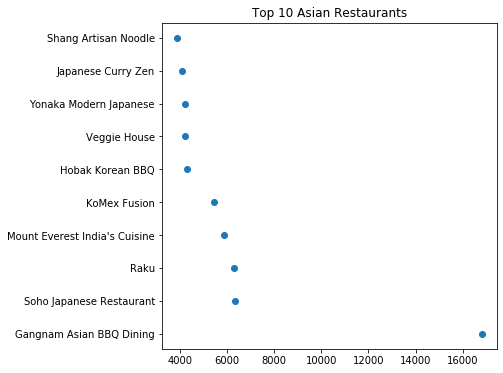

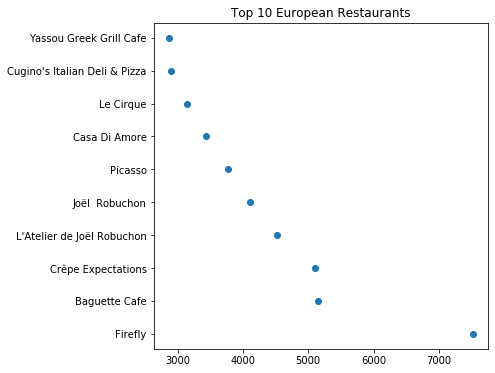

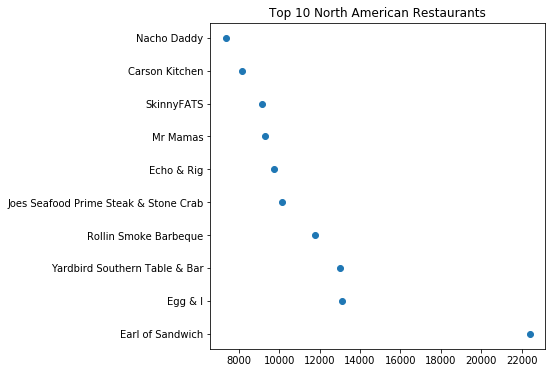

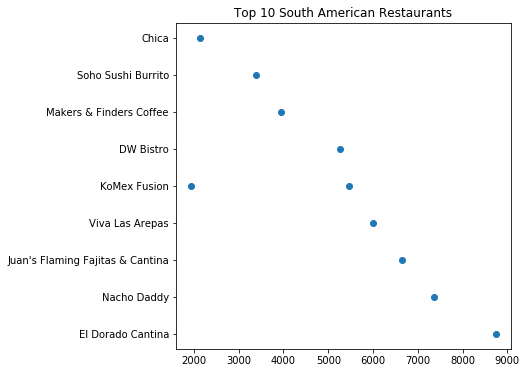

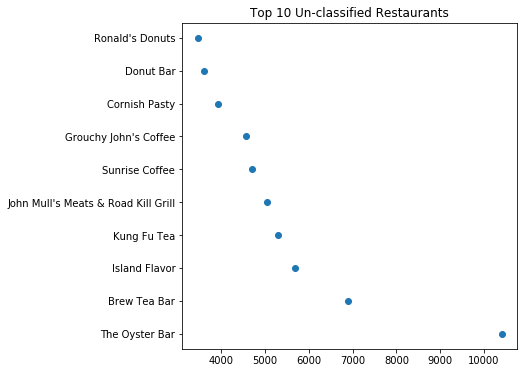

In [0]:
plt.figure(1)
plot_totalstars(asian_df)
plt.title('Top 10 Asian Restaurants')

plt.figure(2)
plot_totalstars(european_df)
plt.title('Top 10 European Restaurants')

plt.figure(3)
plot_totalstars(namerica_df)
plt.title('Top 10 North American Restaurants')

plt.figure(4)
plot_totalstars(samerica_df)
plt.title('Top 10 South American Restaurants')

plt.figure(5)
plot_totalstars(other_df)
plt.title('Top 10 Un-classified Restaurants')



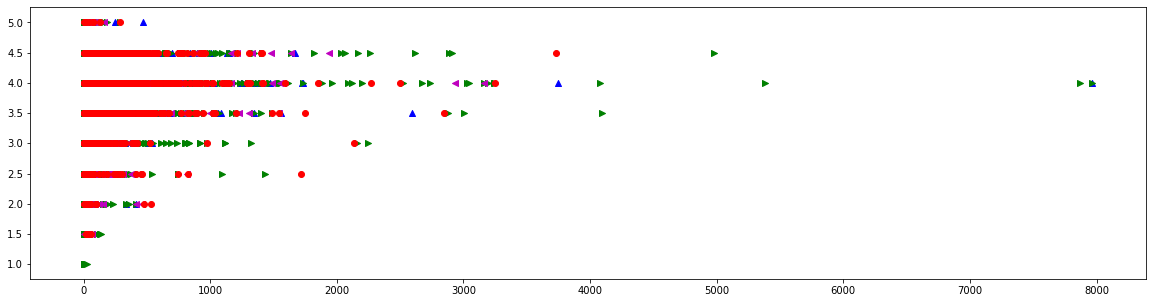

In [0]:
#Plot reviews and stars
fig,ax = plt.subplots(figsize =[20,5])

xA_stars, yA_reviews = vegas_final[vegas_final['asian']==True]['stars'].values, vegas_final[vegas_final['asian']==True]['review_count'].values
xE_stars, yE_reviews = vegas_final[vegas_final['european']==True]['stars'].values, vegas_final[vegas_final['european']==True]['review_count'].values
xNA_stars,yNA_reviews = vegas_final[vegas_final['namerica']==True]['stars'].values, vegas_final[vegas_final['namerica']==True]['review_count'].values
xSA_stars, ySA_reviews = vegas_final[vegas_final['samerica']==True]['stars'].values,vegas_final[vegas_final['samerica']==True]['review_count'].values
xO_stars,yO_reviews = vegas_final[vegas_final['other']==True]['stars'].values, vegas_final[vegas_final['other']==True]['review_count'].values


plt.scatter(yE_reviews,xE_stars, marker='^',color = 'b')
plt.scatter(yNA_reviews,xNA_stars, marker='>',color = 'g')
plt.scatter(ySA_reviews,xSA_stars, marker='<',color = 'm')
plt.scatter(yA_reviews, xA_stars,color = 'r')

Text(0.5, 1.0, 'Number of restaurants grouped by cuisine')

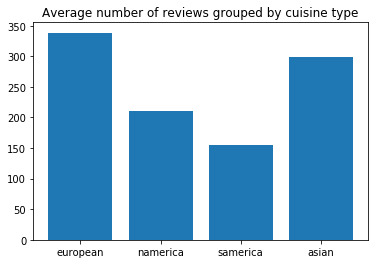

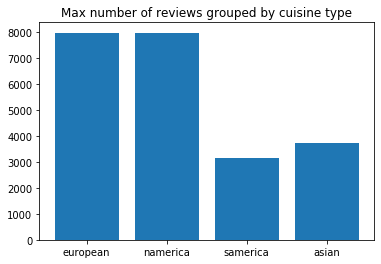

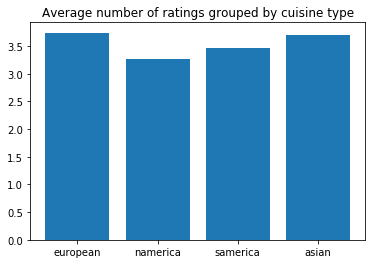

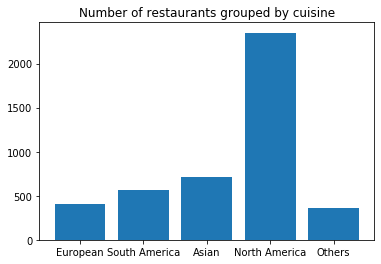

In [0]:
plt.figure(1)
x = ['european','namerica','samerica','asian']
y = [yE_reviews.mean(), yNA_reviews.mean(),ySA_reviews.mean(),yA_reviews.mean()]
plt.bar(x,y)
plt.title('Average number of reviews grouped by cuisine type')

plt.figure(2)
y2 = [yE_reviews.max(), yNA_reviews.max(),ySA_reviews.max(),yA_reviews.max()]
plt.bar(x,y2)
plt.title('Max number of reviews grouped by cuisine type')

plt.figure(3)
y3 = [xE_stars.mean(), xNA_stars.mean(), xSA_stars.mean(), xA_stars.mean()]
plt.bar(x,y3)
plt.title('Average number of ratings grouped by cuisine type')


plt.figure(4)
x = ['European','South America','Asian','North America','Others']
y4 = [len(yE_reviews),len(ySA_reviews),len(yA_reviews),len(yNA_reviews), len(yO_reviews)]
plt.bar(x,y4)
plt.title('Number of restaurants grouped by cuisine')



From the first plot, it seems that European tends to have the highest number of review. But if we check out the last plot, the 'mean' number of reviews might have been skewed by a small number of European restaurants that have a good amount of reviews.

European and Asian restaurants seem to have the highest average ratings. North America is the dominating cuisine but the restaurants in this category tend to have low average rating.

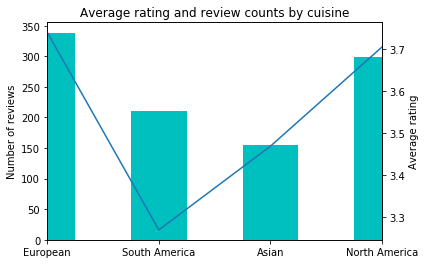

In [0]:
x = ['European','South America','Asian','North America']
df = pd.DataFrame([x,y,y3]).T

df[1].plot(kind ='bar',color ='c')
plt.ylabel('Number of reviews')
df[2].plot(secondary_y=True)
plt.ylabel('Average rating')
# plt.title('Restaurants grouped by cuisine')
plt.xticks(np.arange(4), x)
plt.title('Average rating and review counts by cuisine')

plt.show()

In [0]:
#Export clean data to csv
#vegas_final.to_csv(r'/content/gdrive/My Drive/YELP/yelp-interimdata/vegas_cuisine.csv')

In [0]:
vegas_final.head(5)

,org_index,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,hours,BusinessAcceptsCreditCards,BusinessParking_garage,BusinessParking_street,BusinessParking_validated,BusinessParking_lot,BusinessParking_valet,GoodForKids,WheelchairAccessible,BikeParking,Alcohol,HasTV,NoiseLevel,RestaurantsAttire,Music_dj,Music_background_music,Music_no_music,Music_karaoke,Music_live,Music_video,Music_jukebox,Ambience_romantic,Ambience_intimate,Ambience_classy,Ambience_hipster,Ambience_divey,...,Teppanyaki,Themed Cafes,Tiki Bars,Tobacco Shops,Tours,Towing,Trainers,Transmission Repair,Transportation,Travel Services,Truck Rental,Turkish,Tuscan,Ukrainian,Vegan,Vegetarian,Vehicle Wraps,Venezuelan,Venues & Event Spaces,Videos & Video Game Rental,Vitamins & Supplements,Waffles,Walking Tours,Water Heater Installation/Repair,Water Stores,Waxing,Wedding Chapels,Wedding Planning,Weight Loss Centers,Whiskey Bars,Wholesale Stores,Wholesalers,Windshield Installation & Repair,Wine & Spirits,Wine Bars,Wineries,Women's Clothing,Yelp Events,Yoga,success
8,32,kgffcoxT6BQp-gJ-UQ7Czw,Subway,Summerlin,2255 N Rampart Blvd,Las Vegas,NV,89128,36.201794,-115.281981,2.5,13,1,"Fast Food, Restaurants, Sandwiches","{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,33,0jtRI7hVMpQHpUVtUy4ITw,Omelet House Summerlin,Summerlin,2227 N Rampart Blvd,Las Vegas,NV,89128,36.201990,-115.283122,4.0,242,1,"Beer, Wine & Spirits, Italian, Food, American ...","{'Monday': '7:0-14:30', 'Tuesday': '7:0-19:0',...",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32,141,zhxnD7J5_sCrKSw5cwI9dQ,Popeyes Louisiana Kitchen,Sunrise,4505 E Bonanza Rd,Las Vegas,NV,89110,36.173140,-115.077945,1.5,16,1,"Chicken Wings, Restaurants, Fast Food","{'Monday': '10:0-23:0', 'Tuesday': '10:0-23:0'...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
34,143,2kWrSFkIes_d2BMg4YrRtA,Pizza Hut,Sunrise,"560 N. Nellis Blvd, Ste E1",Las Vegas,NV,89110,36.169353,-115.061694,2.5,19,1,"Restaurants, Pizza","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
35,145,6llKs7K_tn8ChXcIM-oTvg,Sansei Japan,Eastside,3480 S Maryland Pkwy,Las Vegas,NV,89169,36.125934,-115.135253,4.5,3,1,"Japanese, Restaurants",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
